## Analysis of data of Moignard *et al.*, Nat. Biotechn. (2015)

Much more explanation on the given problem is found [here](README.md).

This has been published by [Haghverdi *et al.*, Nat. Meth. (2016)](http://dx.doi.org/10.1038/nmeth.3971) together with a Matlab implementation of Diffusion Pseudotime. The data is from [Moignard *et al.*, Nat. Biotechn. (2015)](http://dx.doi.org/10.1038/nbt.3154).

In [1]:
%config InlineBackend.figure_formats = ['retina']  # increase resolution on retina screens
import numpy as np
import scanpy.api as sc

sc.sett.verbosity = 3                # show some output
sc.sett.set_dpi(80)                  # low pixel number yields small inline figures
sc.logg.print_version_and_date()

Running Scanpy version 0.1+54.g320fa42 on 2017-06-15 15:22.


1. Filter out a few genes.
2. Choose a 'root cell'.                                                                                                                                                           
3. Define groupnames by inspecting cellnames.                                                                                                                                    

In [2]:
filename = 'data/moignard15/nbt.3154-S3.xlsx'
backup_url = 'http://www.nature.com/nbt/journal/v33/n3/extref/nbt.3154-S3.xlsx'
adata = sc.read(filename, sheet='dCt_values.txt', backup_url=backup_url)
# filter out genes as done by Haghverdi et al. (2016)
removed_genes = np.in1d(adata.var_names, ['Eif2b1', 'Mrpl19', 'Polr2a', 'Ubc'])
adata = adata[:, ~removed_genes]  # retain non-removed genes
# choose root cell as in Haghverdi et al. (2016)
adata.add['xroot'] = adata.X[532]  # note that in Matlab/R, counting starts at 1
# annotate with Moignard et al. (2015) experimental cell groups
groups_names = ['HF', 'NP', 'PS', '4SG', '4SFG']
# annotate each sample/cell
adata.smp['exp_groups'] = [
    next(gname for gname in groups_names if sname.startswith(gname))
    for sname in adata.smp_names]
# fix the order and colors of names in "groups"
adata.add['exp_groups_names'] = groups_names
adata.add['exp_groups_colors'] = ['#D7A83E', '#7AAE5D', '#497ABC', '#AF353A', '#765099']

... reading file ./write/data/moignard15/nbt.3154-S3.h5


Perform a Diffusion Pseudotime analysis.

In [3]:
sc.tl.dpt(adata, n_branchings=1, k=5, knn=False)

initializing data graph
... using X for building graph
... set iroot 532
start computing Diffusion Map
... determined k = 5 nearest neighbors of each point (0:00:00.324)
... computed W (weight matrix) with "knn" = False (0:00:00.410)
... computed K (anisotropic kernel) (0:00:00.052)
... computed Ktilde (normalized anistropic kernel)
... computed eigenvalues (0:00:00.530)
[ 1.     0.992  0.974  0.887  0.861  0.826  0.781  0.76   0.734  0.73 ]
perform Diffusion Pseudotime analysis
... detect 1 branching
... do not consider groups with less than 50 points for splitting
... branching 1: split group 0 with tip cells = [3617 2614 1306] (0:00:00.004)
finished (0:00:01.082) and added
    "dpt_pseudotime", stores pseudotime (adata.smp),
    "dpt_groups", the segments of trajectories a long a tree (adata.smp),
    "dpt_groups_adjacency", the adjacency matrix defining the tree (adata.add),
    "dpt_order", is an index array for sorting the cells (adata.smp),
    "dpt_grouptips", stores the indice

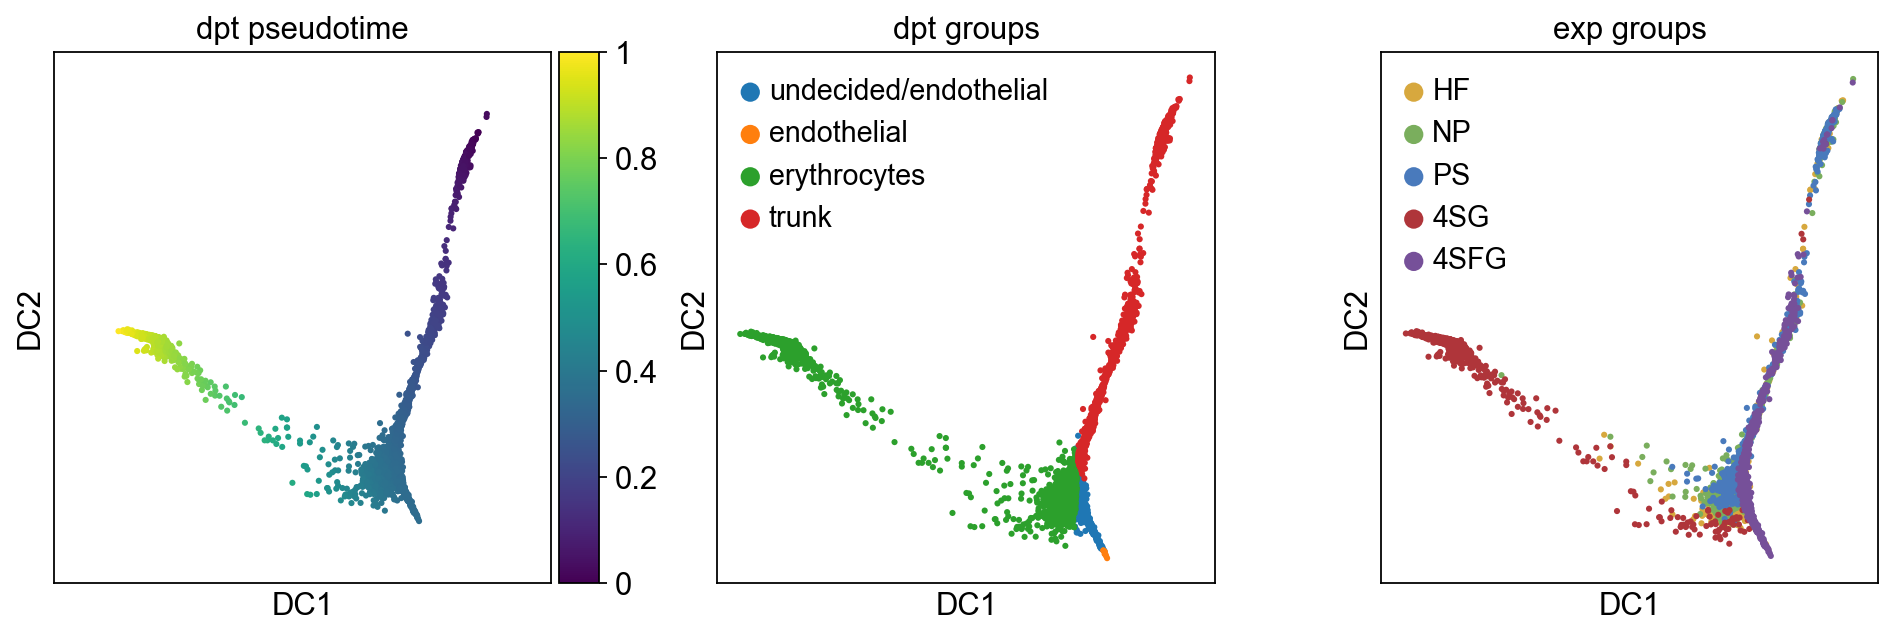

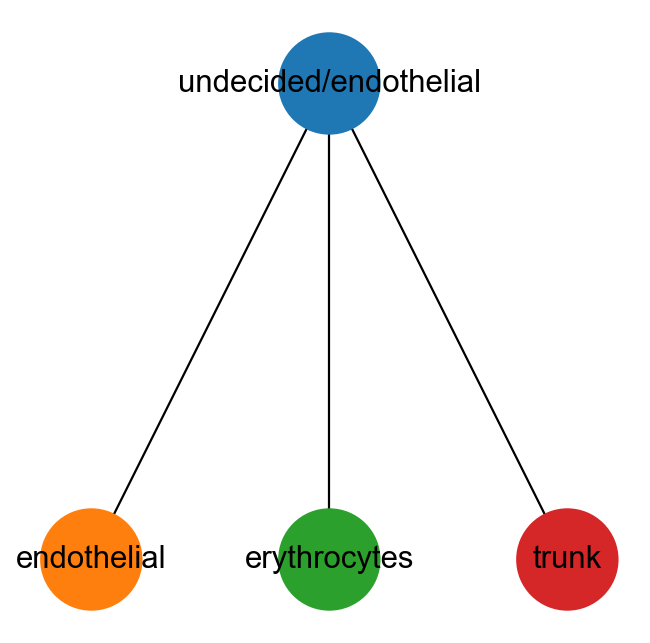

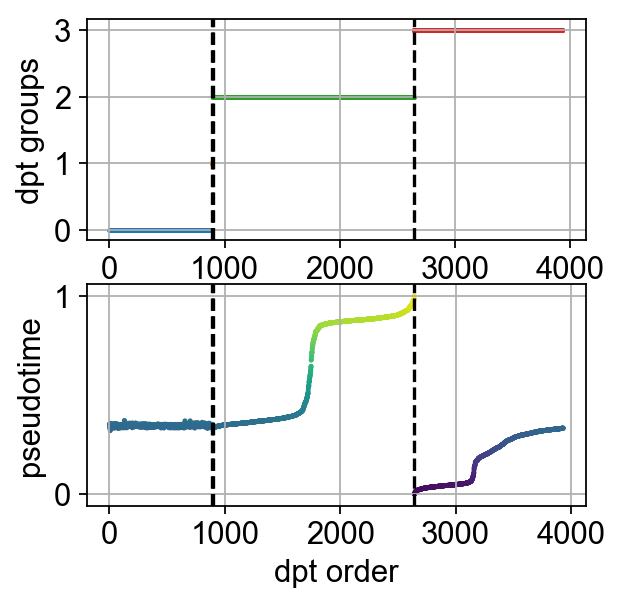

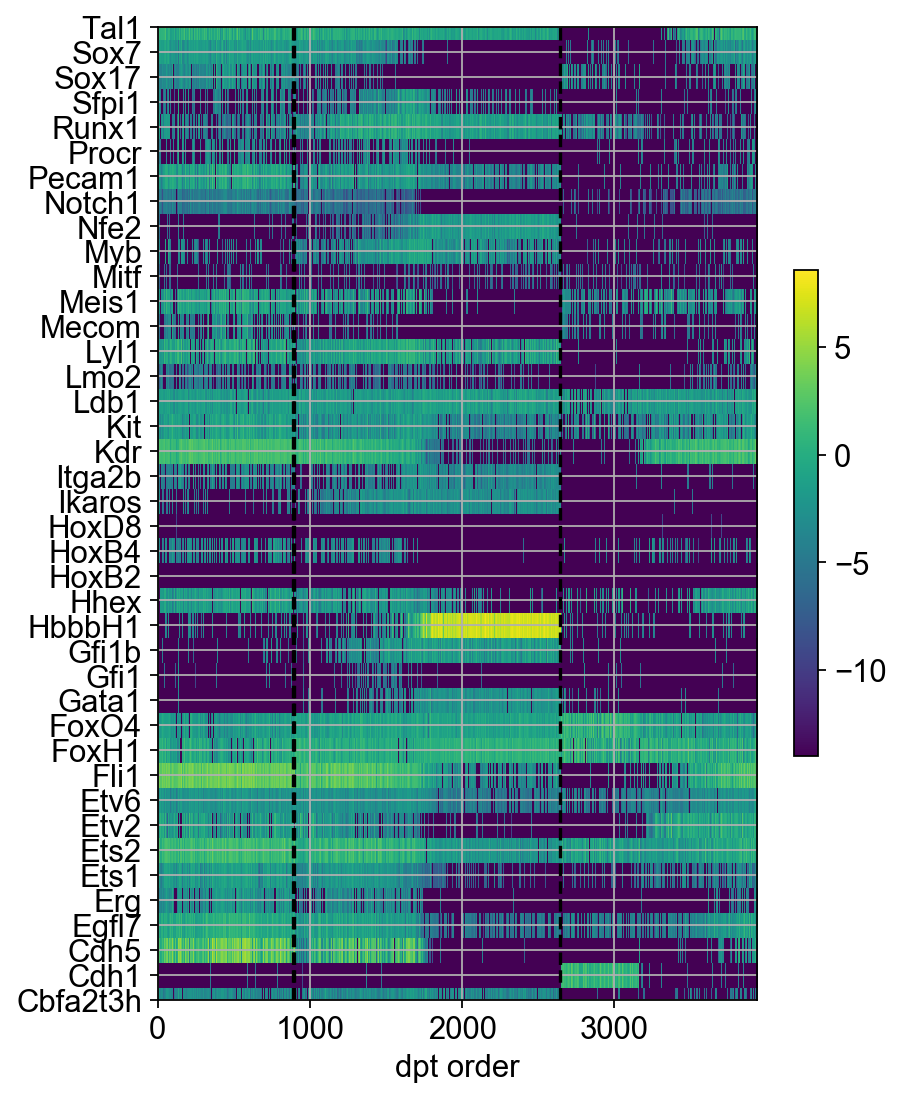

In [4]:
adata.add['dpt_groups_names'] = ['undecided/endothelial', 'endothelial', 'erythrocytes', 'trunk'] # optional
sc.pl.dpt(adata, color=['dpt_pseudotime', 'dpt_groups', 'exp_groups'], legendloc='upper left')

In [5]:
sc.write('moignard15', adata)

... writing ./write/moignard15.h5
